In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 10

In [3]:
from graph_policy import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_SR

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 64

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from models/neuropol-18-09-18-002956/model-7268352


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 20

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [14]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [15]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    #compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

#Sats: 100; avg step: 3.65; stdev step: 1.17; avg error: 0.62; stdev error: 0.69


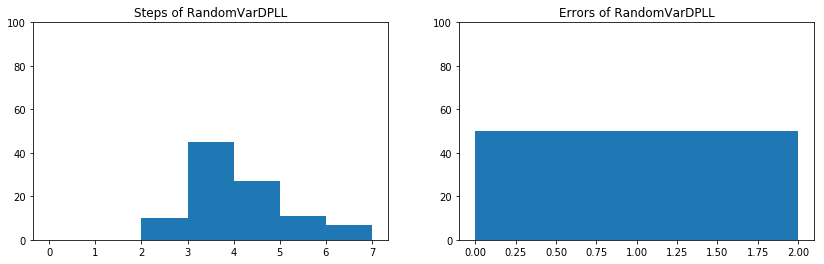

#Sats: 100; avg step: 2.93; stdev step: 0.78; avg error: 0.14; stdev error: 0.35


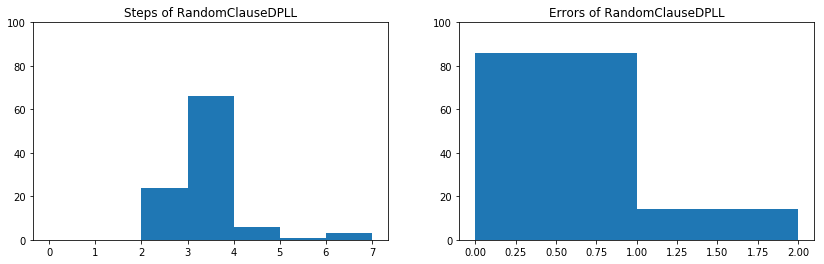

#Sats: 100; avg step: 2.56; stdev step: 0.50; avg error: 0.00; stdev error: 0.00


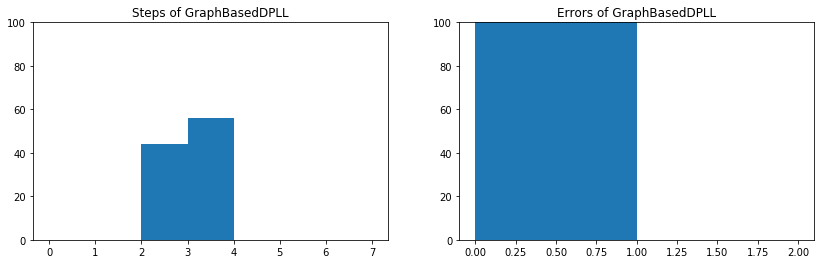

#Sats: 100; avg step: 2.57; stdev step: 0.51; avg error: 0.01; stdev error: 0.10


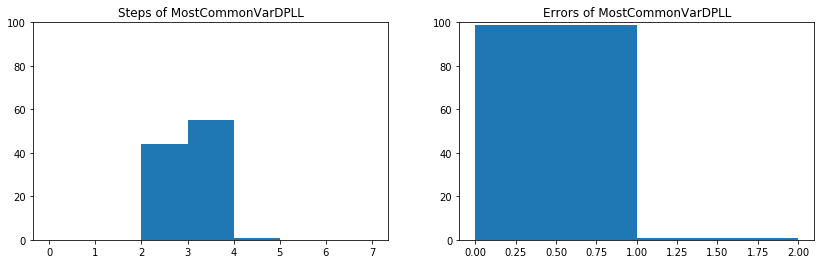

In [16]:
print_all(100, 2, 2, 3)

#Sats: 100; avg step: 8.18; stdev step: 2.64; avg error: 1.93; stdev error: 0.95


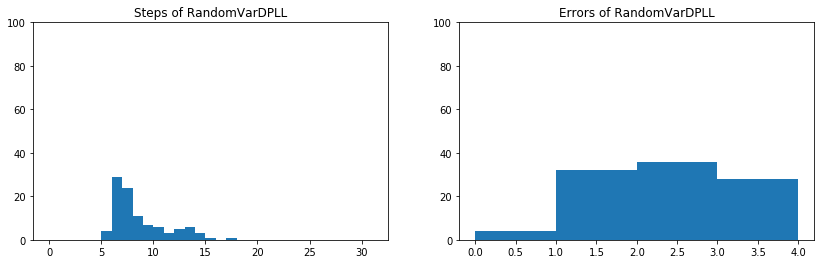

#Sats: 100; avg step: 6.70; stdev step: 2.26; avg error: 0.70; stdev error: 0.70


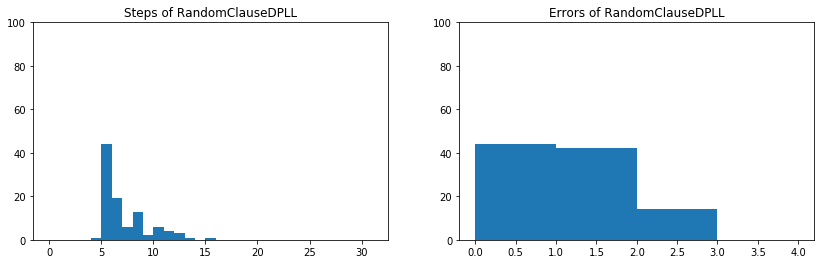

#Sats: 100; avg step: 4.99; stdev step: 0.36; avg error: 0.01; stdev error: 0.10


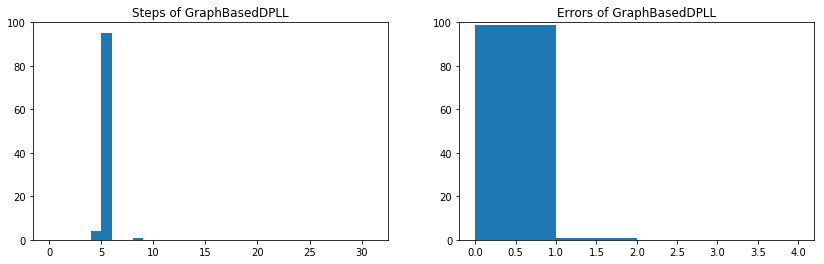

#Sats: 100; avg step: 5.25; stdev step: 1.31; avg error: 0.09; stdev error: 0.32


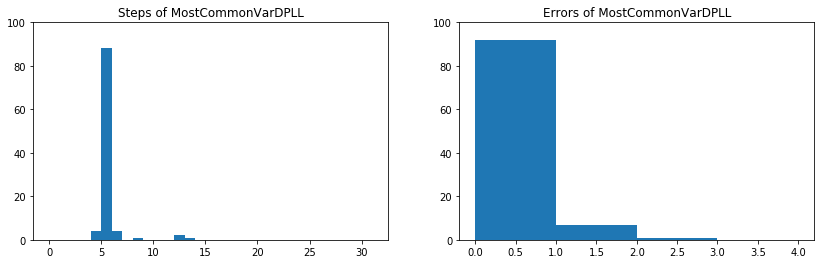

In [17]:
print_all(100, 2, 4, 20)

#Sats: 100; avg step: 7.40; stdev step: 3.49; avg error: 1.05; stdev error: 0.93


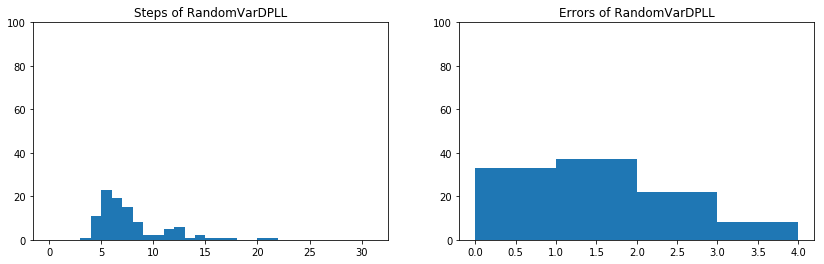

#Sats: 100; avg step: 5.89; stdev step: 2.78; avg error: 0.42; stdev error: 0.57


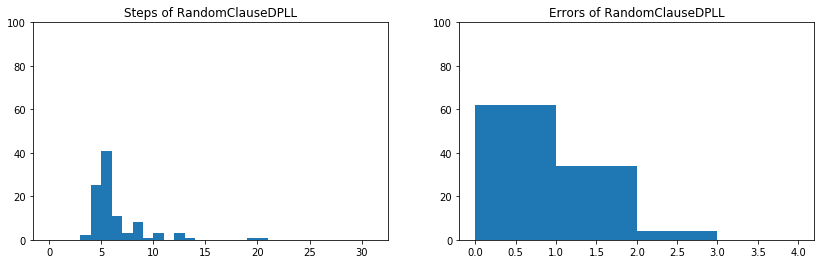

#Sats: 100; avg step: 4.39; stdev step: 0.55; avg error: 0.00; stdev error: 0.00


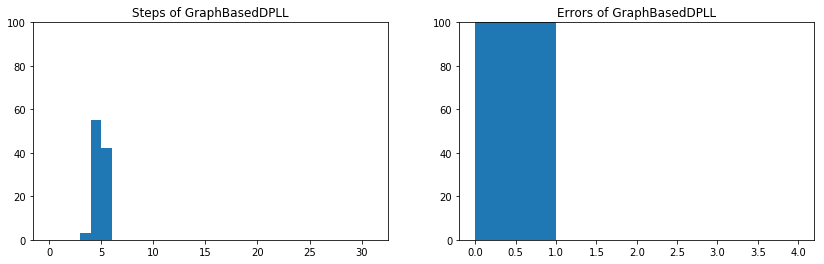

#Sats: 100; avg step: 4.48; stdev step: 1.30; avg error: 0.12; stdev error: 0.38


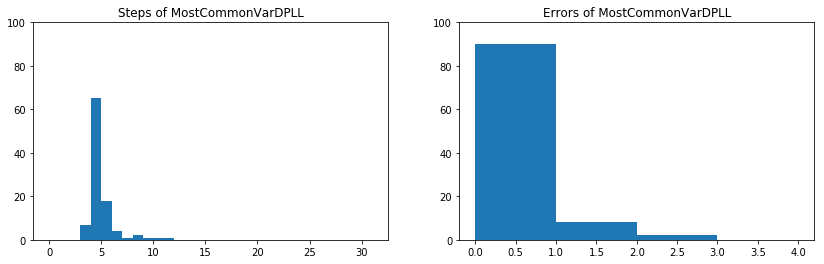

In [18]:
print_all(100, 3, 4, 10)

#Sats: 100; avg step: 11.19; stdev step: 4.85; avg error: 1.87; stdev error: 0.99


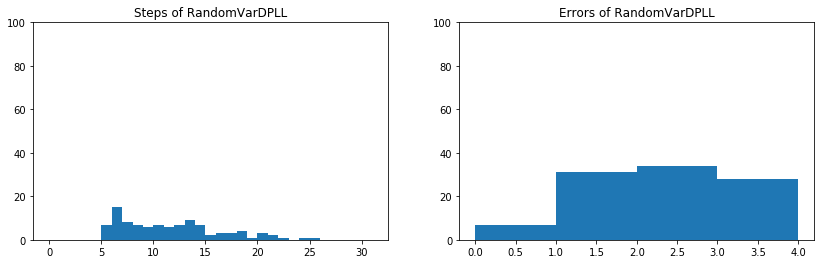

#Sats: 100; avg step: 7.96; stdev step: 3.97; avg error: 0.85; stdev error: 0.78


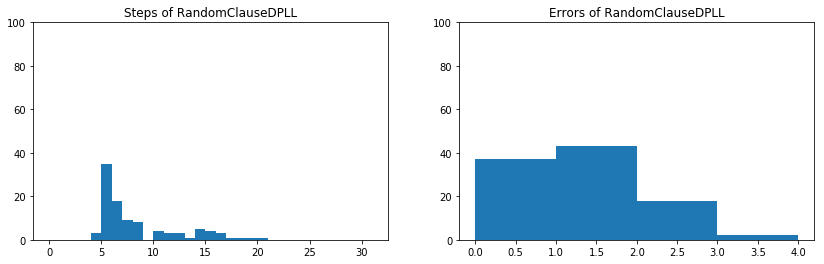

#Sats: 100; avg step: 5.03; stdev step: 0.62; avg error: 0.02; stdev error: 0.14


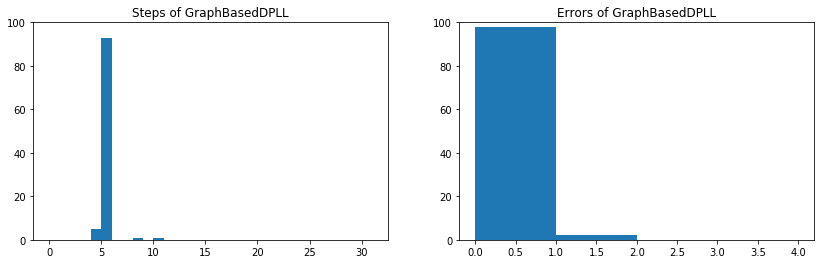

#Sats: 100; avg step: 5.96; stdev step: 2.40; avg error: 0.30; stdev error: 0.52


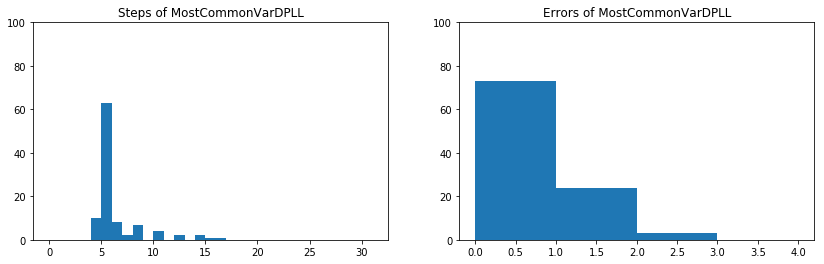

In [19]:
print_all(100, 3, 4, 20)

#Sats: 100; avg step: 9.66; stdev step: 3.37; avg error: 1.96; stdev error: 0.86


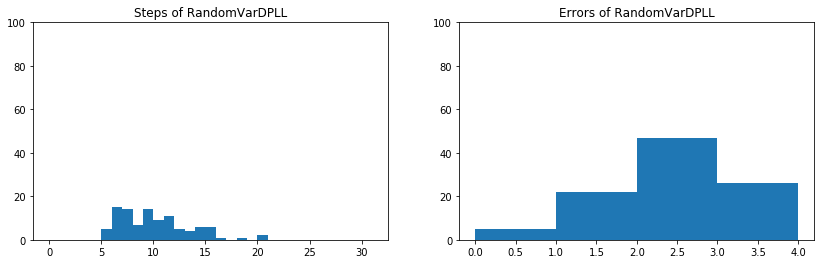

#Sats: 100; avg step: 8.74; stdev step: 3.47; avg error: 1.25; stdev error: 0.82


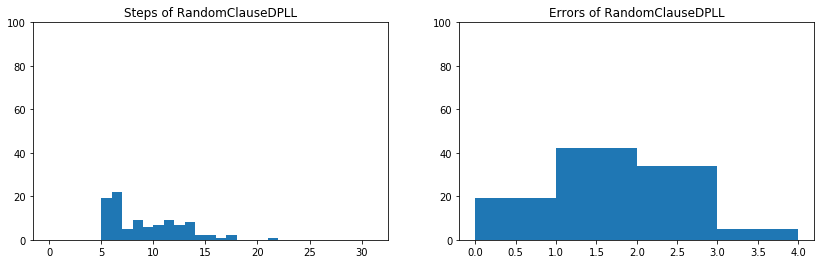

#Sats: 100; avg step: 4.99; stdev step: 0.10; avg error: 0.00; stdev error: 0.00


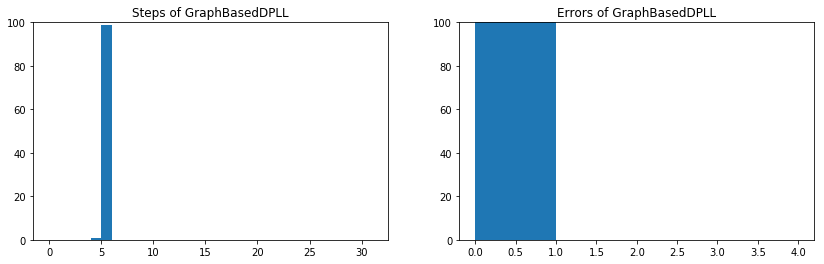

#Sats: 100; avg step: 5.82; stdev step: 1.95; avg error: 0.27; stdev error: 0.53


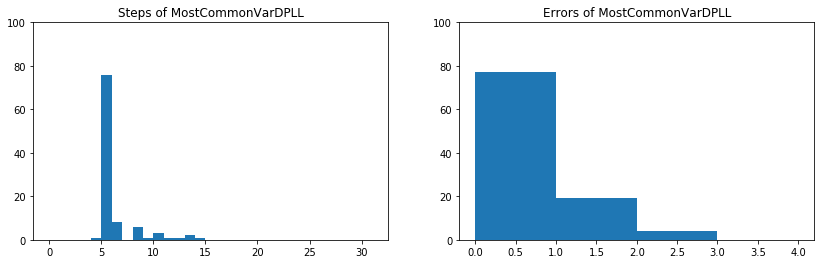

In [20]:
print_all(100, 3, 4, 40)

#Sats: 100; avg step: 14.25; stdev step: 6.92; avg error: 2.11; stdev error: 1.13


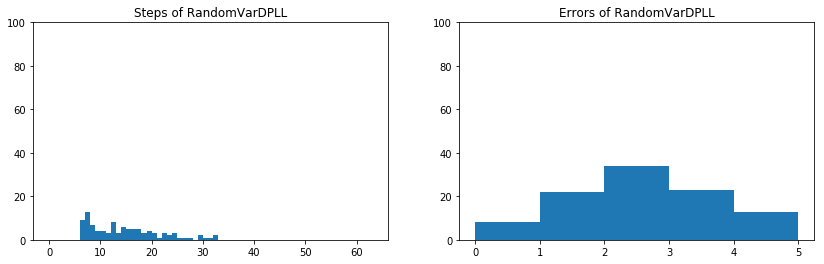

#Sats: 100; avg step: 12.82; stdev step: 6.42; avg error: 1.48; stdev error: 1.05


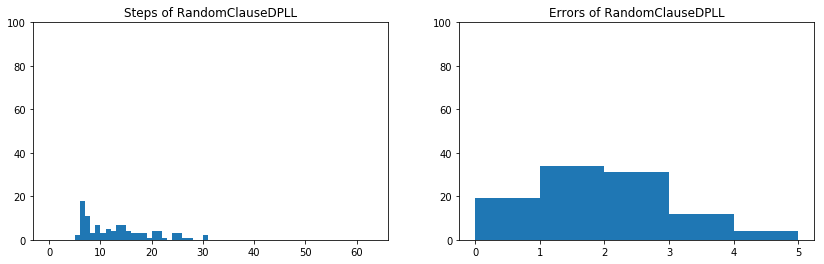

#Sats: 100; avg step: 5.95; stdev step: 0.43; avg error: 0.02; stdev error: 0.14


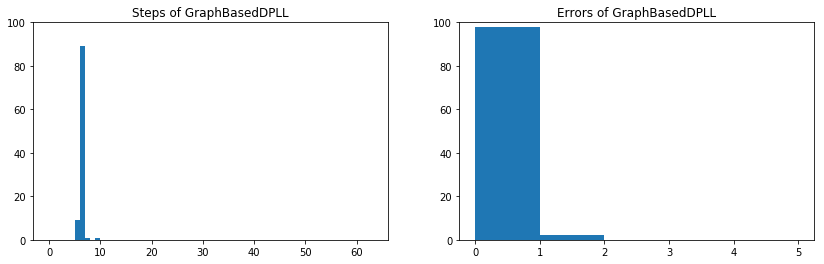

#Sats: 100; avg step: 7.58; stdev step: 3.72; avg error: 0.41; stdev error: 0.60


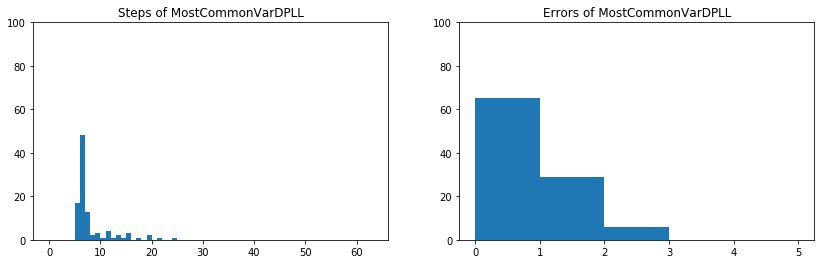

In [21]:
print_all(100, 3, 5, 30)

#Sats: 100; avg step: 13.40; stdev step: 5.15; avg error: 2.31; stdev error: 1.11


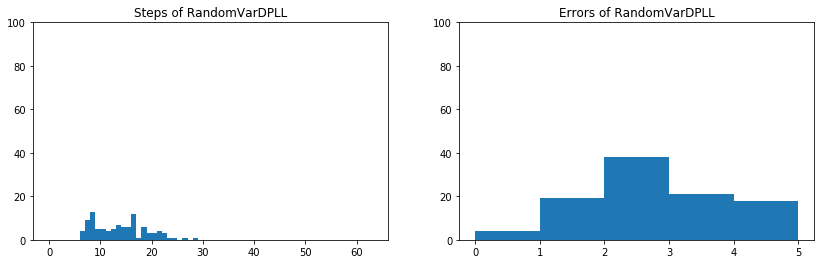

#Sats: 100; avg step: 11.61; stdev step: 5.37; avg error: 1.49; stdev error: 0.99


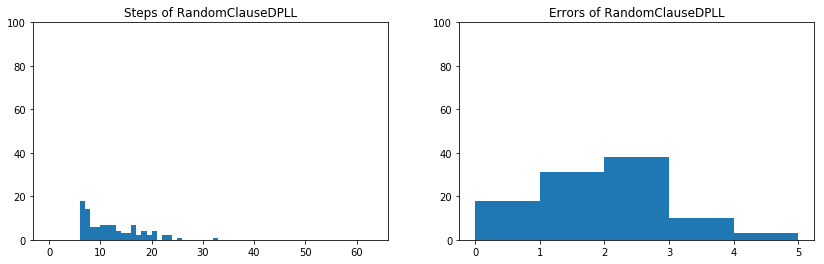

#Sats: 100; avg step: 5.98; stdev step: 0.14; avg error: 0.00; stdev error: 0.00


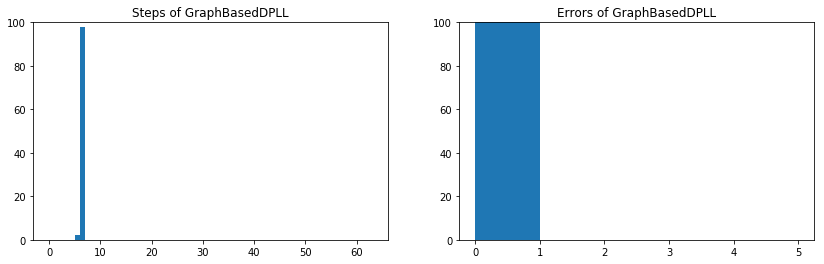

#Sats: 100; avg step: 7.63; stdev step: 3.46; avg error: 0.37; stdev error: 0.56


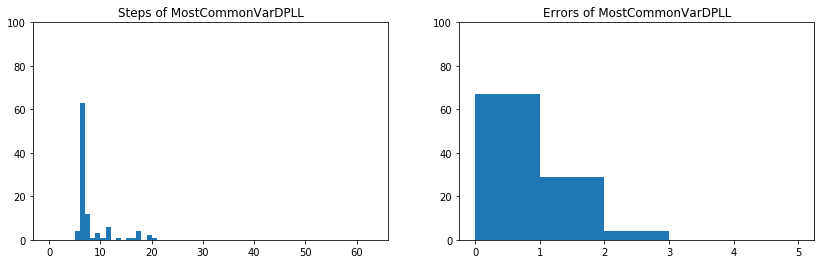

In [22]:
print_all(100, 3, 5, 40)

#Sats: 100; avg step: 21.03; stdev step: 10.41; avg error: 2.79; stdev error: 1.25


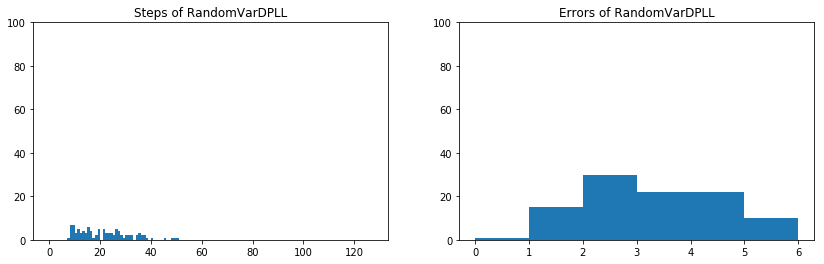

#Sats: 100; avg step: 16.08; stdev step: 8.95; avg error: 1.75; stdev error: 1.04


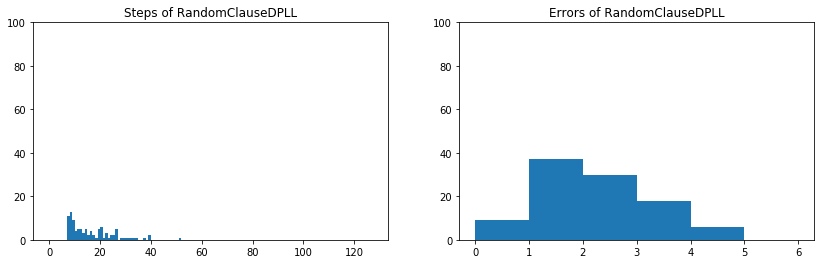

#Sats: 100; avg step: 7.10; stdev step: 1.92; avg error: 0.01; stdev error: 0.10


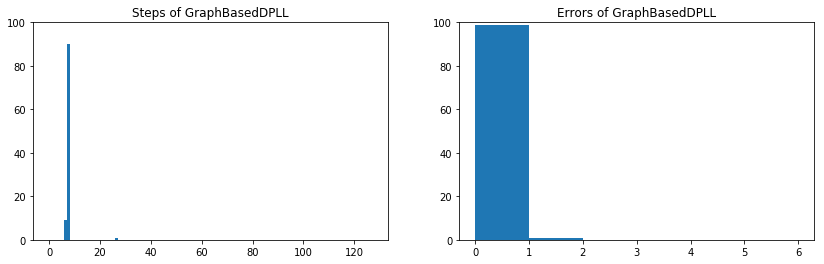

#Sats: 100; avg step: 9.50; stdev step: 4.87; avg error: 0.49; stdev error: 0.66


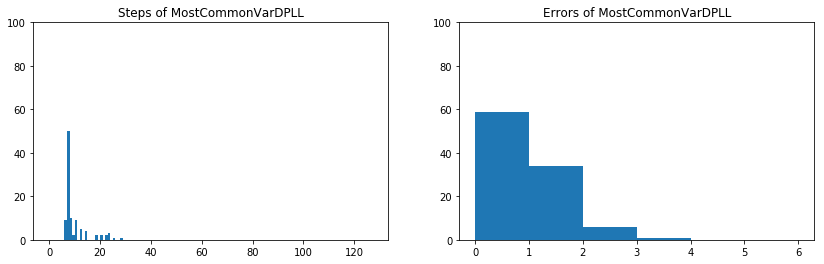

In [23]:
print_all(100, 3, 6, 40)

#Sats: 100; avg step: 17.41; stdev step: 6.83; avg error: 2.95; stdev error: 1.20


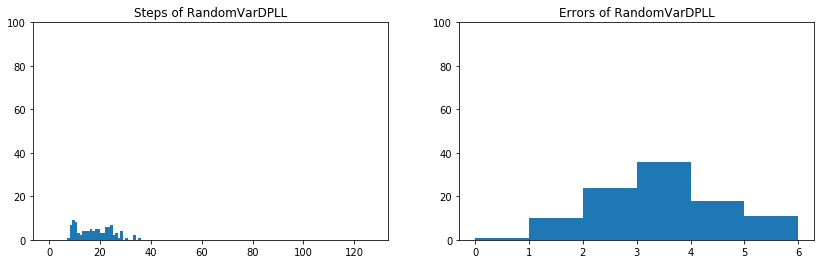

#Sats: 100; avg step: 13.13; stdev step: 5.62; avg error: 1.77; stdev error: 1.03


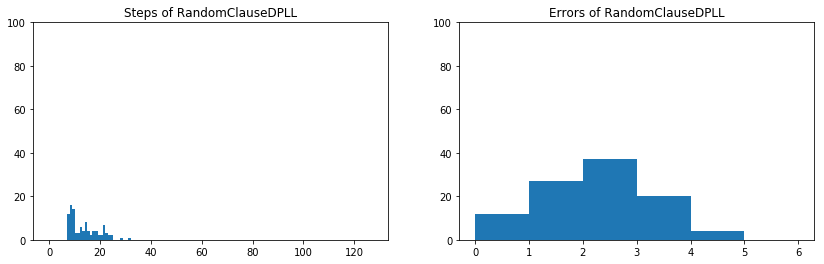

#Sats: 100; avg step: 7.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


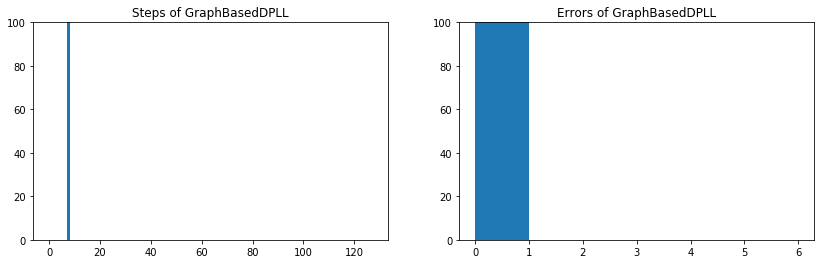

#Sats: 100; avg step: 7.90; stdev step: 2.84; avg error: 0.20; stdev error: 0.42


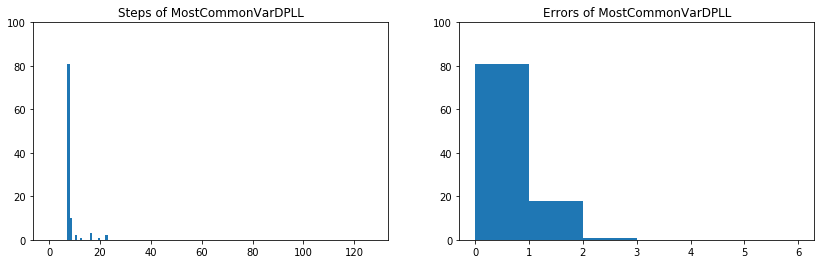

In [24]:
print_all(100, 3, 6, 70)

#Sats: 100; avg step: 19.35; stdev step: 14.26; avg error: 2.09; stdev error: 1.26


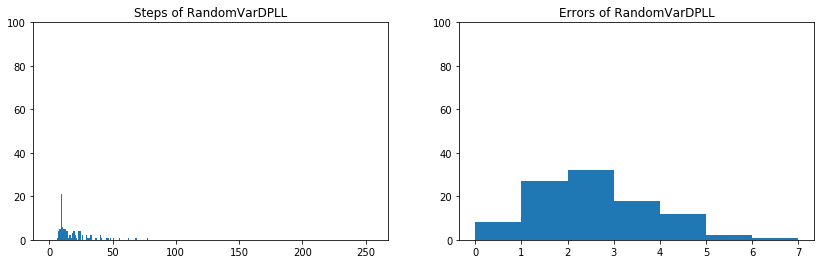

#Sats: 100; avg step: 13.69; stdev step: 10.72; avg error: 0.91; stdev error: 0.95


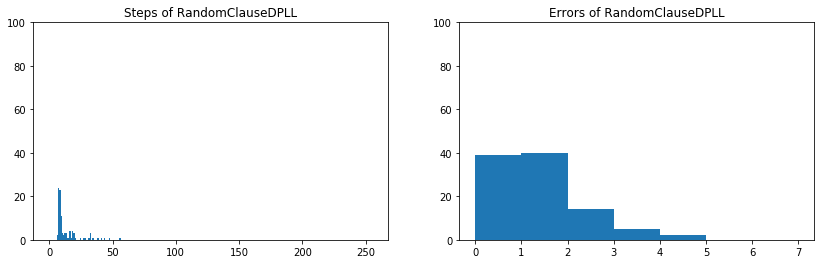

#Sats: 100; avg step: 7.29; stdev step: 1.99; avg error: 0.02; stdev error: 0.14


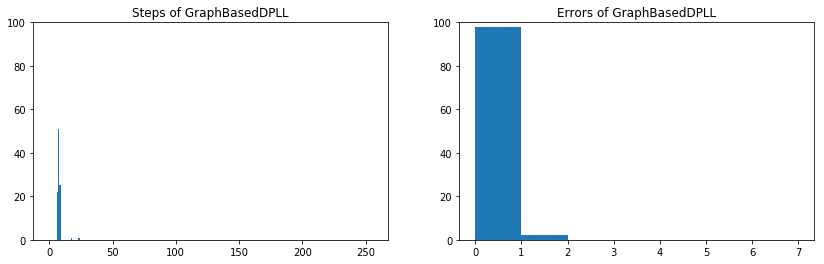

#Sats: 100; avg step: 8.20; stdev step: 4.00; avg error: 0.37; stdev error: 0.61


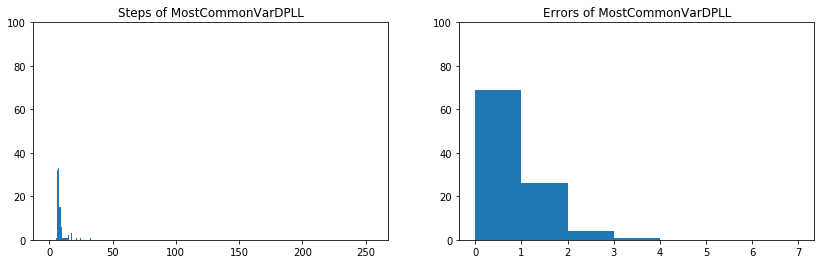

In [25]:
print_all(100, 3, 7, 20)

#Sats: 100; avg step: 24.08; stdev step: 10.75; avg error: 3.62; stdev error: 1.32


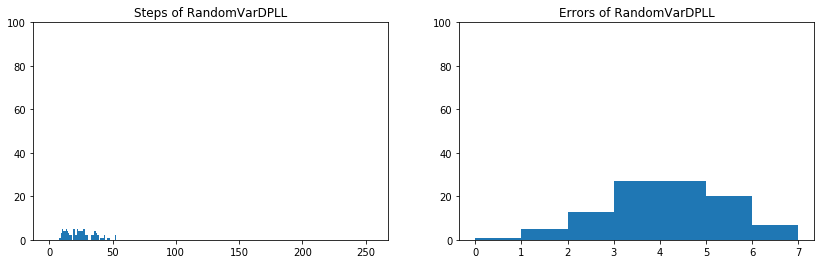

#Sats: 100; avg step: 19.46; stdev step: 8.77; avg error: 2.33; stdev error: 1.03


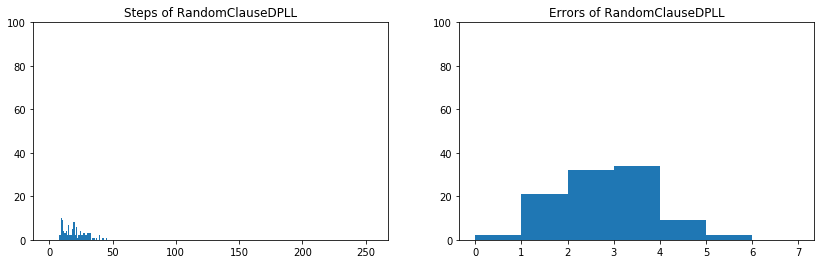

#Sats: 100; avg step: 7.99; stdev step: 0.10; avg error: 0.00; stdev error: 0.00


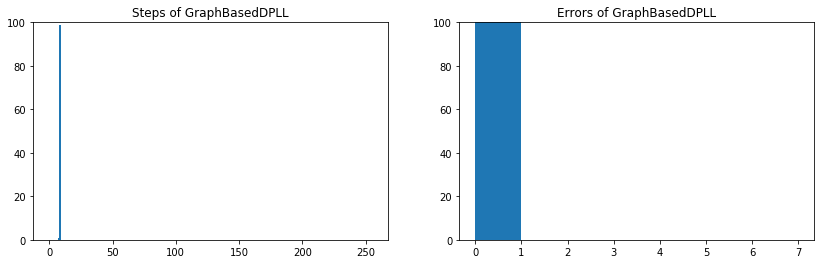

#Sats: 100; avg step: 10.68; stdev step: 5.20; avg error: 0.49; stdev error: 0.61


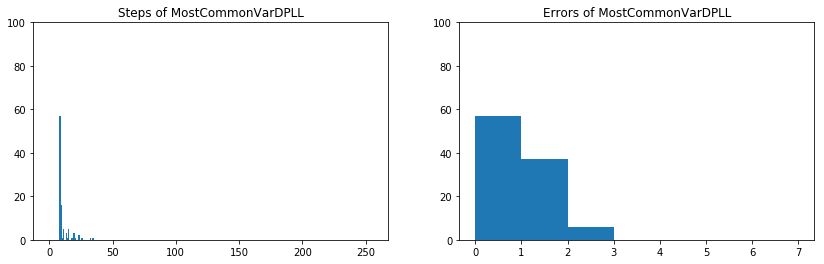

In [26]:
print_all(100, 3, 7, 70)

#Sats: 100; avg step: 39.20; stdev step: 24.99; avg error: 3.53; stdev error: 1.30


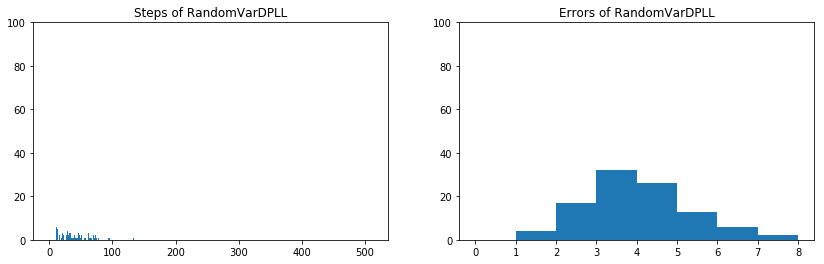

#Sats: 100; avg step: 30.37; stdev step: 20.84; avg error: 1.84; stdev error: 1.15


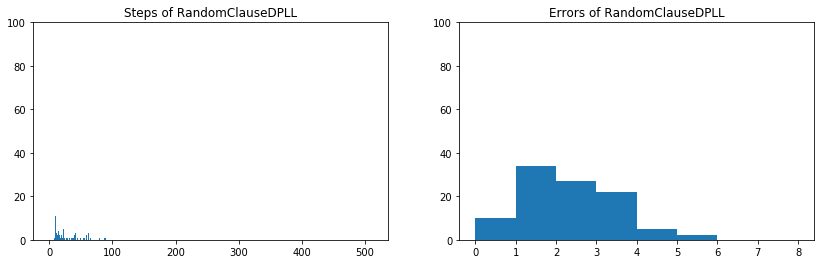

#Sats: 100; avg step: 9.89; stdev step: 6.00; avg error: 0.05; stdev error: 0.22


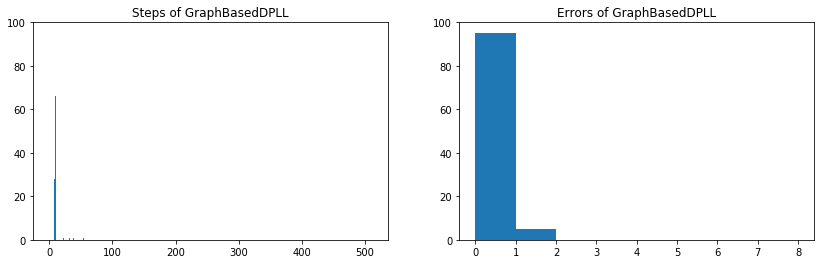

#Sats: 100; avg step: 16.27; stdev step: 12.43; avg error: 0.69; stdev error: 0.80


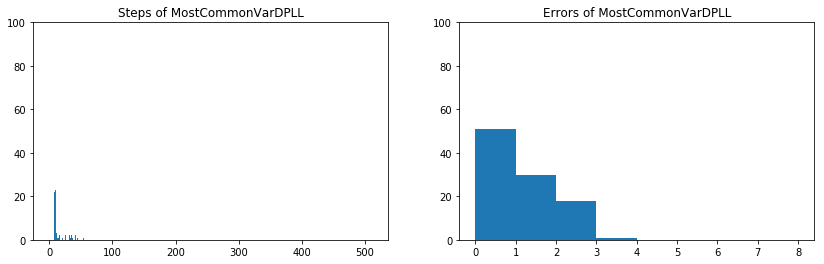

In [27]:
print_all(100, 3, 8, 40)

#Sats: 100; avg step: 35.11; stdev step: 18.41; avg error: 3.66; stdev error: 1.38


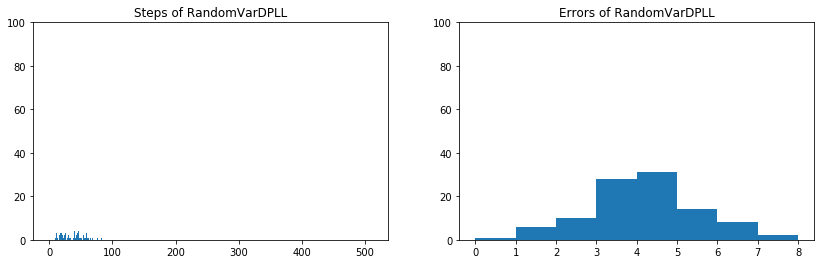

#Sats: 100; avg step: 31.41; stdev step: 18.58; avg error: 2.29; stdev error: 1.25


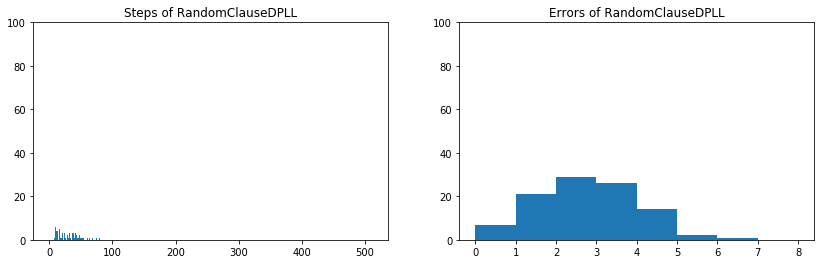

#Sats: 100; avg step: 9.74; stdev step: 5.38; avg error: 0.04; stdev error: 0.20


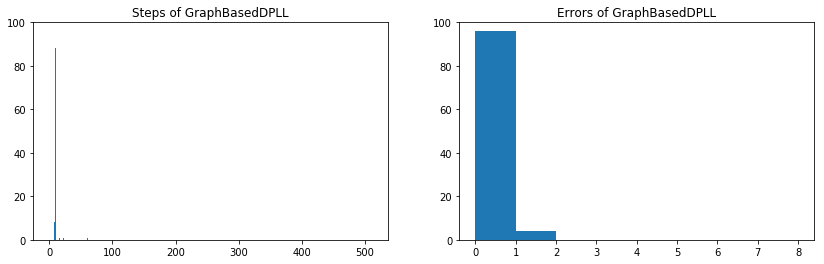

#Sats: 100; avg step: 15.18; stdev step: 10.74; avg error: 0.70; stdev error: 0.77


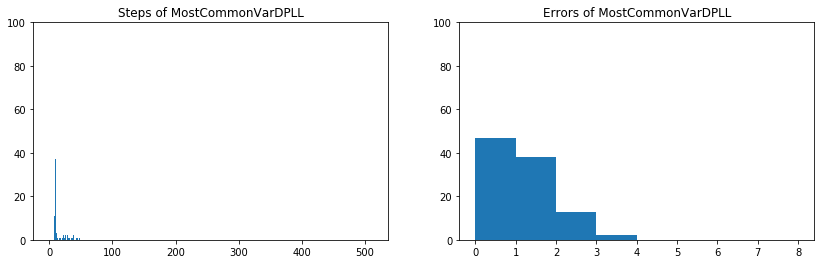

In [28]:
print_all(100, 3, 8, 50)

#Sats: 100; avg step: 72.61; stdev step: 51.99; avg error: 4.59; stdev error: 1.54


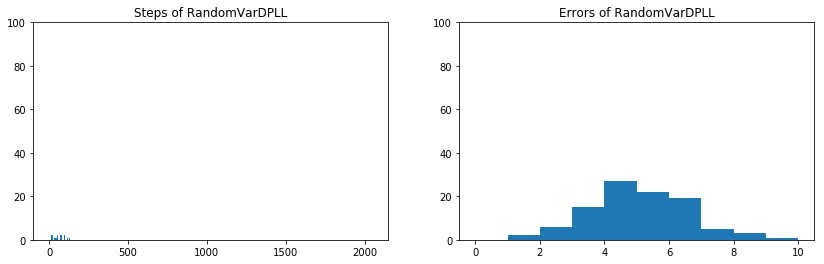

#Sats: 100; avg step: 48.41; stdev step: 35.26; avg error: 2.55; stdev error: 1.33


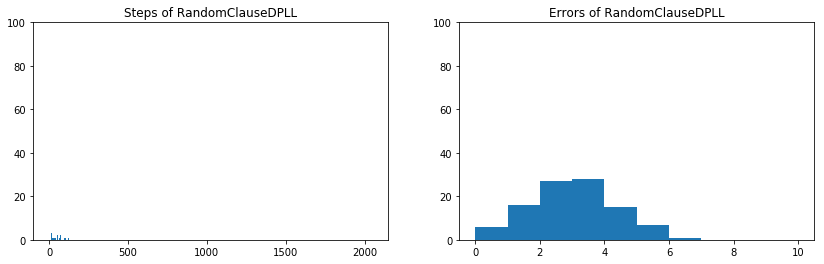

#Sats: 100; avg step: 12.39; stdev step: 7.35; avg error: 0.07; stdev error: 0.26


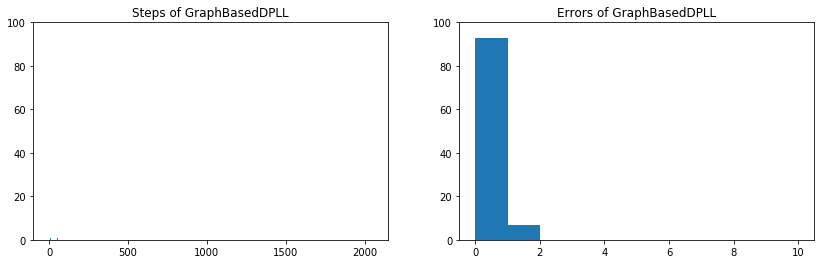

#Sats: 100; avg step: 20.78; stdev step: 17.19; avg error: 0.91; stdev error: 0.94


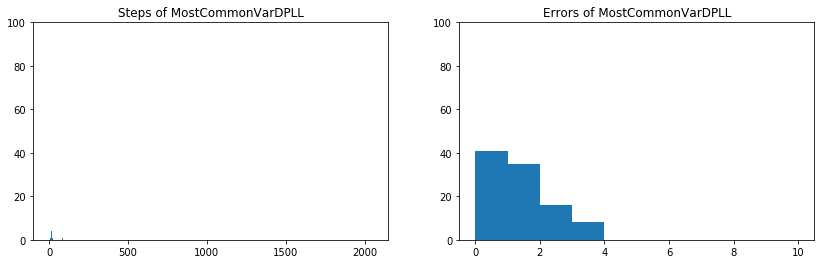

In [29]:
print_all(100, 3, 10, 50)